In [1]:
import pandas as pd
import datetime
import numpy as np
import urllib.request
import json
import requests
from datetime import datetime
import matplotlib.pyplot as plt
#import seaborn as sns

# disable scientific notation and set decimal places
pd.options.display.float_format = '{:.4f}'.format

# disaply column and row to the maximum length
pd.set_option('display.max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

## Set Parameters

In [2]:
maturity_condition = 'days_to_maturity < 500'

selected_maturity = datetime(2024, 5, 26).strftime('%Y-%m-%d') # Only used for term structure comparison

## Get Deribit Data

In [3]:
url =  "https://deribit.com/api/v2/public/get_instruments?currency=BTC&kind=option&expired=false"
with urllib.request.urlopen(url) as url:
    get_inst_names = json.loads(url.read().decode())

inst_names = pd.DataFrame(get_inst_names['result'])#.set_index('instrument_name')
inst_names['creation_date'] = pd.to_datetime(inst_names['creation_timestamp'], unit='ms')
inst_names['expiration_date'] = pd.to_datetime(inst_names['expiration_timestamp'], unit='ms')


api_data_list = []

for x in inst_names['instrument_name']:
    url = f'https://www.deribit.com/api/v2/public/get_order_book?instrument_name={x}&kind=option&expired=false'
    with urllib.request.urlopen(url) as response:
        api_data = json.loads(response.read().decode())

    api_data_df = pd.DataFrame([api_data])
    api_data_list.append(api_data_df)

all_data = pd.concat(api_data_list, ignore_index=True)
all_data = pd.json_normalize(all_data['result'])

## Organize Data

In [4]:
index = ['instrument_name', 
         'bid_iv', 
         'ask_iv', 
         'mark_iv',
         'greeks.delta',
         'greeks.gamma',
         'greeks.theta',
         'greeks.vega',
         'greeks.rho',
         'mark_price',
         'index_price', # Spot index price
         'underlying_index', # Name of the underlying Futures
         'underlying_price', # Mark price of the corresponding Futures; Deribit uses SYN price when there is no corresponding future yet on market
         'estimated_delivery_price', 
         'settlement_price',
         'open_interest']

data = all_data[index]
exclude_columns = ['instrument_name', 'underlying_index']
data = data.apply(lambda x: pd.to_numeric(x, errors='ignore') if x.name not in exclude_columns else x)

In [5]:
strike = []
for index, i in enumerate(data['instrument_name']):
    i = float(i.split('-')[2])
    strike.append(i)
data["strikePx"] = strike

maturity = []
for index, i in enumerate(data['instrument_name']):
    i = i.split('-')[1]
    i = pd.to_datetime(i, unit ='ns')
    maturity.append(i)
data["maturity"] = maturity

days_to_maturity = []
for index, i in enumerate(data['maturity']):
    i = (i - datetime.today()).days
    days_to_maturity.append(i)
data["days_to_maturity"] = days_to_maturity


# Moneyness, using forward price
data['moneyness'] = data['strikePx'].astype(float)/ data['underlying_price'].astype(float)
# 'underlying price' is the price of corresponding Futures

#log Moneyness, making extreme values less extreme
#data['moneyness'] = np.log(data['strikePx'].astype(float)/ data['fwdPx'].astype(float)) 


data.loc[data['instrument_name'].str.contains('-P'), 'moneyness'] = data.loc[data['instrument_name'].str.contains('-P'), 'moneyness'] * -1

data = data.sort_values(['days_to_maturity','strikePx']).query('days_to_maturity > 0')
all_calls = data[data['instrument_name'].str.contains('-C')].sort_values(['days_to_maturity', 'strikePx']).query('days_to_maturity > 0')
all_puts = data[data['instrument_name'].str.contains('-P')].sort_values(['days_to_maturity', 'strikePx']).query('days_to_maturity > 0')

In [6]:
# Only include options that have less than 150 days until expiration
#data = data.query(maturity_condition)

all_calls = data[data['instrument_name'].str.contains('-C')].sort_values(['days_to_maturity', 'strikePx']).query('days_to_maturity > 0')
all_puts = data[data['instrument_name'].str.contains('-P')].sort_values(['days_to_maturity', 'strikePx']).query('days_to_maturity > 0')

## Interpolate IV Surface

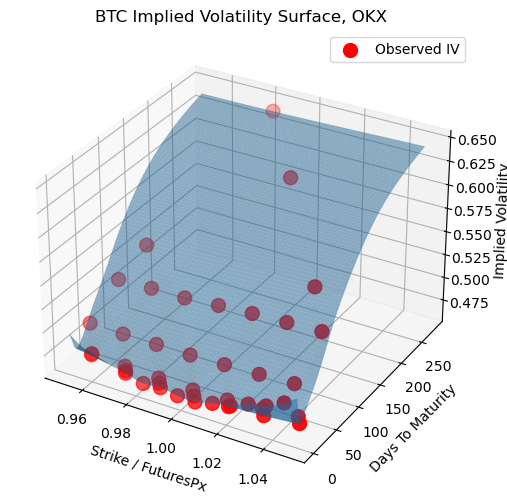

In [7]:
from pandas.io.json import json_normalize
from scipy import interpolate
import statsmodels.api as sm
from mpl_toolkits import mplot3d
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook 

# Interpolate implied volatility using a cubic spline
'''
Cubic Spline interpolation uses cubic polynominals to interpolate between data points

'''

def plot_iv_surf(x,y,z,x2=None,y2=None,z2=None,label=''):
    fig = plt.figure(3, figsize=(6,6))
    ax=plt.axes(projection='3d')
    ax.set_title('BTC Implied Volatility Surface, OKX')
    ax.set_zlabel('Implied Volatility')
    plt.xlabel('Strike / FuturesPx')
    plt.ylabel('Days To Maturity')
    #ax.zaxis.set_major_formatter(FuncFormatter(lambda z, _: '{:.0%}'.format(z)))
    if z2 is not None:
        ax.scatter3D(x2,y2,z2, c='r', s=100,label=label)
    ax.plot_surface(x, y, z, rstride=1, cstride=1,alpha=0.5)
    ax.legend()
    

x = data['moneyness']
y = data['days_to_maturity']
z = data['mark_iv']/100

X,Y = np.meshgrid(np.linspace(.95,1.05,99),np.linspace(1,np.max(y),100))
Z = interpolate.griddata(np.array([x,y]).T,np.array(z),(X,Y), method='cubic')

xyz = pd.DataFrame({'x':x,'y':y,'z':z})
xyz = xyz.query('x>0.95 & x<1.05')
plot_iv_surf(X,Y,Z,xyz['x'],xyz['y'],xyz['z'],'Observed IV')

iv_df = pd.DataFrame(Z, index=np.linspace(10,np.max(y),100), columns=np.linspace(.95,1.05,99))

### For Ref, Non-Interpolated

Text(0.5, 0.92, 'OKEX Implied Volatility Scatter Plot')

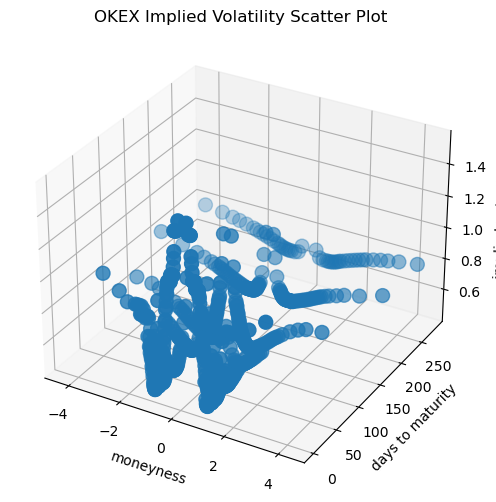

In [8]:
#%matplotlib notebook 

a = data['moneyness']
b = data['days_to_maturity']
c = data['mark_iv']/100

plt.rcParams['figure.figsize'] = (13,6)

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter3D(a, b, c, s = 100)

ax.set_xlabel('moneyness')
ax.set_ylabel('days to maturity')
ax.set_zlabel('implied volatility')

#ax.view_init(45,215);
plt.title('OKEX Implied Volatility Scatter Plot')

## Term Structure

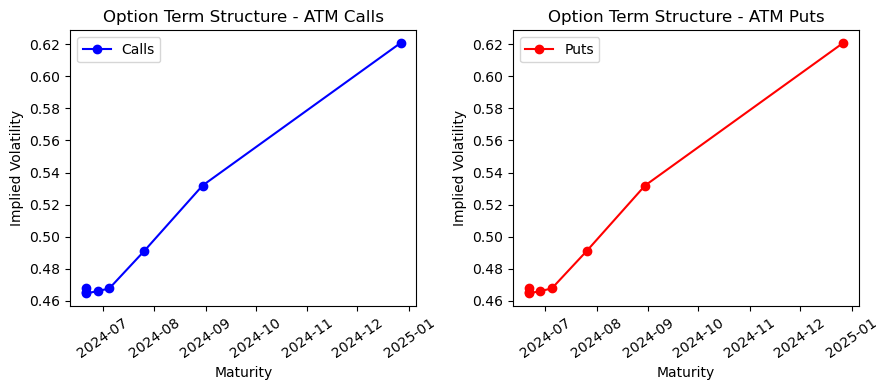

In [9]:
tolerance = 0.01 # rare to have moneyness = 1 or -1, this include some buffer

atm_options = data[(abs(data['moneyness'] - 1.00) <= tolerance) | (abs(data['moneyness'] + 1.00) <= tolerance)]
atm_options_1 = atm_options.set_index('maturity').sort_index().query('days_to_maturity > 0')

calls = atm_options_1[atm_options_1['instrument_name'].str.contains('-C')]
puts = atm_options_1[atm_options_1['instrument_name'].str.contains('-P')]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# Plot option term structure for calls
ax1.plot(calls['mark_iv']/100, label='Calls', marker='o', color='blue')
ax1.set_title('Option Term Structure - ATM Calls')
ax1.set_xlabel('Maturity')
ax1.set_ylabel('Implied Volatility')
ax1.legend()


# Plot option term structure for puts
ax2.plot(puts['mark_iv']/100, label='Puts', marker='o', color='red')
ax2.set_title('Option Term Structure - ATM Puts')
ax2.set_xlabel('Maturity')
ax2.set_ylabel('Implied Volatility')
ax2.legend()

ax1.tick_params(axis='x', labelrotation=35)
ax2.tick_params(axis='x', labelrotation=35)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## Skewness

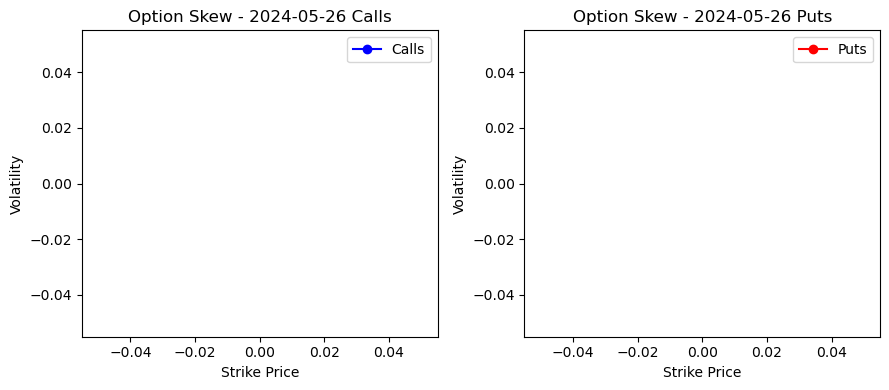

In [11]:
selected_maturity = datetime(2024, 6, 20).strftime('%Y-%m-%d') # Only used for term structure comparison

calls_match_dtm = all_calls[all_calls['maturity'] == selected_maturity].set_index('strikePx').sort_index()
puts_match_dtm = all_puts[all_puts['maturity'] == selected_maturity].set_index('strikePx').sort_index()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# Plot option skew for calls
ax1.plot(calls_match_dtm['mark_iv']/100, label='Calls', marker='o', color='blue')
ax1.set_title(f'Option Skew - {selected_maturity} Calls')
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Volatility')
ax1.legend()

# Plot option skew for puts
ax2.plot(puts_match_dtm['mark_iv']/100, label='Puts', marker='o', color='red')
ax2.set_title(f'Option Skew - {selected_maturity} Puts')
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Volatility')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
#cp Deribit_VolSurf.ipynb ~/Desktop/